# Filtro de partículas - 2018


Todo seu trabalho deve ficar no arquivo `projeto_pf.py`, que deve ficar num repositório Git privado (que pode estar no Github ou no Gitlab). Você deve adicionar os professores  em seu repositório (fabiomiranda@insper.edu.br  e andrewtnk@insper.edu.br )

A idéia é que você trabalhe somente na `projeto_pf.py` e use este *notebook* somente para instruções e para testar o que fez. Quando seu projeto estiver pronto o arquivo GIF gerado vai mostrar as partículas convergindo para a posição do robô.

Cada partícula vai ser representada por um objeto da classe `Particle`, do arquivo `pf.py`, que contém os atributos `x`,`y`,`theta` e `W`.  O atributo `W` é a probabilidade. 

Este projeto é individual. Lembre-se dos [princípios de honestidade de código](https://docs.google.com/document/d/e/2PACX-1vTiAczPm5Vxi7TXphB135LFH-Munp9X8ISHkeujrTvJtOmQaCC1iAUkoPdHgvkWhIkLsE0e1-T3ZGJ3/pub).




# Atividades


1. Crie uma função que gera n partículas aleatórias distribuídas uniformemente dentro de uma área minx, miny, maxx, maxy, n_particulas (passados como parâmetros). Veja a funcao `create_particles` no módulo `pf` para se inspirar. Sua função deve se chamar `cria_particulas` e ficar no arquivo `projeto_pf.py`.  
Esta função deve devolver o número de partículas solicitado

2. Crie uma função que aplica o deslocamento pelo qual o robô padrão [delta, delta_theta] normal com um desvio padrão [std_deslocamento, std_theta] a todas as partículas.  Esta função deve se chamar `move_particulas` e está também no arquivo `projeto_pf.py`. As partículas têm uma função `move_relative` que facilita aplicar um deslocamento linear no sentido em que a partícula está orientada.

3. Descubra como calcular $P(D|H)$ analisando o Python Notebook. A função que traça os raios está no modulo inspercles e de chama `inspercles.nb_lidar`.

Programe a aplicação da equação <font color=red>modificada</font> baseada na que está na pág. 853 do livro do Norvig $$P(z_t | x_t) = \alpha \sum_{j}^M{e^{\frac{-(z_j - \hat{z_j})^2}{2\sigma^2}}}$$

Dica: veja nos slides da aula a semelhança desta fórmula com a normal. Você pode usar `norm.pdf` para calcular.

Nota: A equação do livro usa uma produtória, mas é muito difícil convergir usando a versão do livro. Na prática (e no ROS) usa-se a equação modificada com a somatória

Para cada raio real medido do robô $\hat{z_j}$ e leitura simulada da partícula $z_j$ calcule a probabilidade daquela leitura da partícula ter acontecido se o robô estivesse na posição em que a partícula está

Faça o traçado dos raios e o cálculo da probabilidade na função `leituras_laser_evidencias`, que também está no arquivo `projeto_pf`. Este traçado limita-se à função `nb_lidar`. Os *frontends* Jupyter e PyGame já fazem todo o desenho.

Note que o valor dos $P(H)$ calculados a cada iteração devem ir para o atributo `W` dos objetos da classe partículas. 

4 . Reamostre as partículas de forma proporcional à probabilidade na função `reamostrar`. Baseie-se no `notebook` chamado `como_sortear`, mas lembre-se de que você precisa incluir uma variação normal às partículas reproduzidas.  **Lembre-se também que depois de reamostrar as partículas precisam ter seu peso W tornado igual novamente**.

### Testando a versão PyGame

A versão `PyGame` usa as mesmas funções do `projeto_pf`, com a diferença que o filtro de partículas é executado passo a passo.

Para instalar PyGame

    conda install pygame
    
ou
    pip install pygame
    
Para executar, no Python 2 faça:

    python window.py
    
No Python 3 faça:

    pythonw window.py


Para funcionar bem com  versão PyGame, adote um desvio padrão do movimento das partículas bem pequeno, da ordem de 0.1 pixels. Quando o filtro de partículas é testado nesta modalidade o robô se move pouco de cada vez

### Atenção:

Instale o pacote attrs fazendo:

    conda install attrs



In [31]:
import projeto_pf # Seu trabalho fica em projeto_pf. Você não deveria precisar editar este notebook

import inspercles
import graphics_nb

import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline


if (sys.version_info > (3, 0)): 
    # Modo Python 3
    import importlib
    importlib.reload(projeto_pf) # Para garantir que o Jupyter sempre relê seu trabalho
else:
    # Modo Python 2
    reload(projeto_pf)



## Diretório de trabalho

In [32]:
print(os.getcwd())



C:\Users\Hugo\Desktop\Insper\Robótica C\cs\robot18\projeto2


Criação das partículas: chamamos a função `projeto_pf.cria_particulas()` para fazer a criação inicial. Estamos armazenando na própria `projeto_pf`. 

In [33]:
projeto_pf.particulas = projeto_pf.cria_particulas()



    

## Mapa com posição inicial

Você **não** precisa se preocupar com as funções de desenho. 

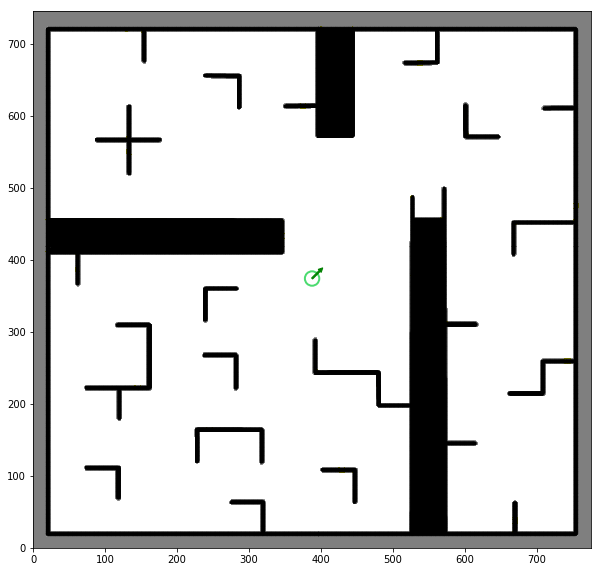

In [34]:
graphics_nb.draw_map(projeto_pf.robot)

# Simulação da imagem do laser

Para simular a leitura **real** do robo, use `inspercles.nb_lidar` passando o objeto robô. 

Você vai precisar fazer isso dentro da função `leituras_laser_evidencias`(que está em `projeto_pf.py`). Haverá uma leitura simulada para o robô e uma simulada para cada partícula

In [35]:
r = projeto_pf.robot
leituras = inspercles.nb_lidar(r, projeto_pf.angles)


O *array* leituras é um dicionário em que as chaves são os ângulos do laser relativos ao robô e o valor é a distância em *cm* em que um obstáculo foi observado naquela direção

In [36]:
leituras

{0.0: 294.8635277547903,
 0.7853981633974483: 235.0,
 1.5707963267948966: 53.033008588991066,
 2.356194490192345: 320.5,
 3.141592653589793: 145.66399692442883,
 3.9269908169872414: 133.0,
 4.71238898038469: 190.2117241391813,
 5.497787143782138: 134.5}

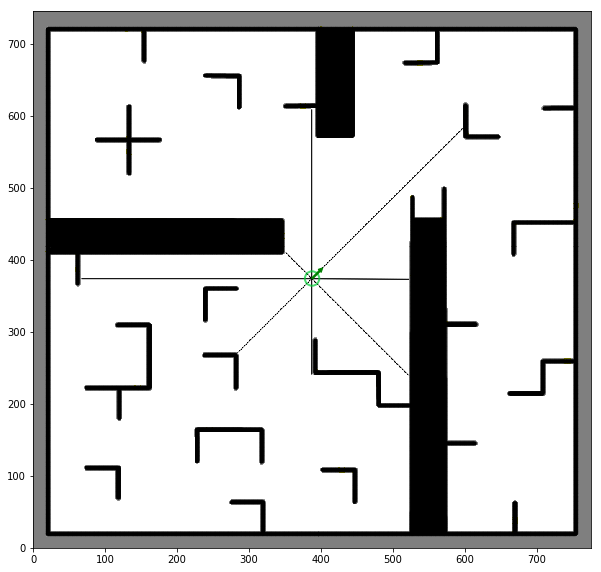

In [37]:

# Você não deve se preocupar com o código abaixo - é só para gerar uma imagem que será mostrada mais adiante
#leituras, inspercles.lidar_map = inspercles.nb_simulate_lidar_fast(projeto_pf.robot.pose(), projeto_pf.angles, inspercles.np_image)
leituras, lidar_map_temp = inspercles.nb_simulate_lidar_desenha(projeto_pf.robot, projeto_pf.angles)

#plt.imshow(lidar_map_temp)
ax = inspercles.nb_draw_map(lidar_map_temp, robot=True, pose=projeto_pf.robot.pose())
#ax.imshow(inspercles.color_image, alpha=0.8)



## Loop principal dos movimentos do robô

Há uma lista de deslocamentos para o robô chamada `movimentos` no arquivo `projeto_pf`. Vamos usá-la para simular o movimento no filtro de partículas




Atenção: quando for gerar os arquivos png da entrega por favor apague todos os arquivos do tipo anim*png antes de gerar a versão final

In [38]:
# No Windows: 
!del anim*png

Could Not Find C:\Users\Hugo\Desktop\Insper\Rob¢tica C\cs\robot18\projeto2\anim*png


In [39]:
# No Linux ou Mac
! rm anim*png

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [40]:
## Atenção: Você não deveria precisar mexer no código abaixo


plt.ioff() # Desliga o modo interativo, para nao aparecerem muitas imagens no meio por causa da animação

frames = 1



for delta in projeto_pf.movimentos:
    
    projeto_pf.robot.move_relative(delta)

    projeto_pf.move_particulas(projeto_pf.particulas, delta)
        
    # Simula a leitura do lidar para o robô - versão desenho
    #leituras, inspercles.lidar_map = inspercles.nb_simulate_lidar_fast(projeto_pf.robot.pose(), projeto_pf.angles, inspercles.np_image)
    leituras, lidar_saida = inspercles.nb_simulate_lidar_desenha(projeto_pf.robot, projeto_pf.angles)
    
    # Simula a leitura - versao codigo
    
    
    # Simula o lidar para as particulas
    # ATENÇÃO: o "for" abaixo faz parte do que deve estar dentro do seu 
    # leituras_laser_evidencias (parte da resolucao do item 3)
    #for p in projeto_pf.particulas:
    #    leituras = inspercles.nb_lidar(p, projeto_pf.angles)
        
    # Atualiza probabilidade e posicoes
    projeto_pf.leituras_laser_evidencias(projeto_pf.robot, projeto_pf.particulas)
    
    # Reamostra as particulas
    projeto_pf.particulas = projeto_pf.reamostrar(projeto_pf.particulas)
    
    
    # Desenha as particulas
    ax = inspercles.nb_draw_map(lidar_saida, pose=projeto_pf.robot.pose(), robot=True, particles=projeto_pf.particulas)
    #ax = inspercles.nb_draw_map(lidar_saida, particles=projeto_pf.particulas)
    # Desenha o mapa do lidar como fundo
    ax.imshow(lidar_saida, alpha=1.0)
    
    plt.savefig("anim%04d.png"%frames, bounds="tight")
    
    frames+=1
    plt.close('all')


plt.ion()



[2.151476419379914e-08, 0.0026901018678699355, 3.2891093437175925e-08, 0.0019208423817798279, 9.512748204939491e-28, 0.0027766249797818955, 7.298306279968392e-08, 4.73440612439823e-18, 1.3366661376078744e-05, 3.302448359706553e-53, 1.2419490490555655e-07, 2.3041650168939283e-23, 0.0008076322687969928, 7.750049667685104e-39, 1.1287777751959109e-05, 2.7517713770904494e-05, 4.763668519210365e-05, 0.005491391712695404, 1.699070499343284e-10, 2.479505490085021e-06, 8.262951596973306e-10, 5.801050127127061e-10, 0.0034228534007795896, 7.98802984449302e-17, 0.005122673007100055, 4.8696109811453105e-28, 0.003968823533622481, 2.4139128397088993e-19, 4.973926276888115e-09, 0.00459518891982371, 0.005893581230603437, 0.0008078046760625848, 0.0005981694788108687, 0.00339984270292184, 6.394955414560917e-19, 3.897693444646883e-27, 0.004729844689934772, 0.0028682657749617706, 1.0726255410507313e-06, 7.030121056862079e-31, 1.8368724683977486e-22, 3.7981152401579127e-10, 1.299876280392568e-22, 0.00089861

[0.001468709143069217, 0.0029936374254369053, 0.0002479466028498499, 2.2571432158065462e-13, 0.002942902152918624, 0.002407429205729982, 3.1134519454706796e-39, 0.002349354037705697, 0.0005114111843295638, 0.0002193788916830025, 0.002062412541249125, 0.00033814654672769886, 2.3672402034789264e-42, 0.0012988525645408926, 0.00045227701131671694, 8.385928824581617e-42, 0.0005013055791142838, 0.0053625890709789814, 0.0032966909778737938, 0.000570845511347111, 4.190438844750553e-09, 0.002323887827150482, 0.0014905803278356905, 5.898514142144134e-24, 0.0021065540207206505, 9.058911704225007e-06, 0.00556728175594267, 0.0003194672281269801, 9.8454466270188e-09, 6.665013605273108e-19, 8.798571406528762e-05, 0.0022691354828437774, 0.004668305501338126, 0.0023587301718483488, 2.3934044698701274e-27, 0.004055536402960845, 0.001582719162030934, 0.0003201419076505687, 0.004522994328876858, 1.5236406276559986e-26, 3.623674970845641e-13, 0.004174116035865116, 0.00025186528355982285, 0.0014820415624752

[0.003329809283607949, 5.139015820315133e-05, 0.0022652621469719312, 1.58668087738446e-08, 3.988134670260968e-31, 0.0005367161362945313, 0.0020859465049657194, 0.0020786800202516977, 0.00025483353875975013, 0.0003059652406015292, 0.0032708343577898097, 0.0001094255323666593, 0.0022871353029504634, 1.2912863306733632e-05, 4.708203275661455e-09, 1.8251285249424019e-31, 0.002061425440956201, 1.1710536077228003e-05, 0.0009018423275671904, 0.0015108562614434655, 0.0012038812537058725, 3.442482119116247e-10, 0.0005601153435714335, 0.004278889264179988, 0.0019688740684971617, 0.0004905296825318536, 5.737141048391732e-12, 0.0011141651434959105, 0.00011812430614270943, 0.003143099619446763, 0.0005438433841478466, 0.00018078405950910315, 8.034964465249048e-33, 0.0034666061762549574, 0.0005623718769578397, 0.001318990404042021, 0.0010007692127218452, 0.0016499452148345491, 1.779572744302434e-06, 0.0019504163185184407, 4.7518096185784064e-05, 0.002328915541460375, 5.351829532342088e-10, 0.00243476

[0.002155103822907833, 4.260116419667288e-06, 2.043524369572869e-27, 2.9345165842256415e-07, 6.677837845265744e-06, 0.001896013153216058, 0.0015117697848613682, 0.0005065816155143023, 0.0012896057873109342, 0.0066683220946064485, 1.2553861735605833e-30, 0.0006770551035424227, 0.001771801248678712, 0.0031627107661379847, 0.003570479923676097, 0.0016233612199016733, 0.00018113774427641507, 0.001382241327981749, 4.342162979455928e-05, 0.0029477576605823493, 0.0017412483652900143, 0.0019783304870165446, 0.00039710883136523324, 0.0015687086465775895, 0.0003707650358742617, 0.0018064230188669169, 0.0011494028996029656, 0.0023000709838935977, 0.003037840989806112, 9.343232036068696e-06, 6.532634285223618e-07, 0.0005830558596435883, 0.00016739668526883776, 3.100775683616066e-05, 7.928184336370316e-05, 0.0002631695772525634, 0.003043868684332571, 0.0014942169255950895, 0.002671769203673847, 0.0008582568676351472, 0.0006345430346426452, 8.073484374836624e-31, 4.817479659946388e-06, 5.73288604592

[0.001596494637700186, 0.002191907429926154, 0.0002526892596790547, 0.0024751977854800444, 1.3606087368090864e-09, 0.00023123385692489705, 0.003059151440071708, 0.000826170790023085, 0.001848936848254419, 0.0005342924878612124, 0.000998061349338224, 0.00014066006433796527, 1.8800098670011796e-09, 0.0004714736484466534, 0.0015005335693943024, 0.0022145672571571447, 0.0012557277302820834, 0.0011486947593382709, 2.0550688872935477e-44, 0.0001676118461237049, 6.0302936093639215e-05, 0.0014453007168957316, 9.166884501420878e-05, 0.0016154748324807616, 0.00048813755152220733, 0.0018042246894858984, 2.1527449536346477e-05, 4.308099791046674e-06, 0.0028496309075128176, 3.9532391525309976e-05, 1.3006336065510875e-06, 0.001850412782149592, 1.855067377806838e-12, 0.0015907911192209032, 0.0012924253803274126, 0.0005067788962361523, 0.0028385676543763506, 0.001060126638743066, 0.001164636411637534, 1.3247415977441578e-05, 0.0016757665750819874, 3.965666644227407e-12, 9.41649703172651e-05, 8.6698417

[0.0010354026462911494, 0.0002559115459984557, 0.0022904919616024977, 2.4937581950686542e-11, 0.0010016153997487937, 7.899399924671701e-05, 0.001350399076195781, 0.0010721064413830054, 1.714293369877306e-05, 1.1644700385602715e-05, 0.0010689581205969112, 1.1712525430449115e-05, 0.0008190715696978922, 0.00043666361767148975, 0.0019897793587920153, 0.0012352924776362257, 0.0015025518888242076, 0.0004331294261220484, 2.424655898113154e-05, 0.00019922973710048456, 0.0008422915475358624, 0.0013541818886292605, 0.002231054365037394, 0.00030514063467386004, 0.0013900117530614253, 0.0010552554385934605, 0.001561399633058381, 0.0009484534257804009, 0.001093373488209678, 0.00011505203224716273, 0.00017638502393775443, 0.003002085846830229, 0.0013140140966610013, 1.9202180631451382e-05, 3.860078872953276e-06, 0.0023463323078256283, 0.0007742000679735373, 0.002012878636503926, 7.485900657730058e-07, 1.3986964331602412e-07, 3.0299601038920405e-08, 0.0005662126807680811, 0.0005904545991339068, 2.613

[0.0019274519521387734, 5.528393892640251e-05, 0.0008426557138849772, 0.000955924013297123, 0.0005620315356554157, 0.00023498865390384824, 0.0018439388043043337, 0.0018130697018935754, 1.4181303699035765e-33, 0.0004687182859915149, 0.0025039872690014284, 0.00018321194060317463, 0.00013265721102133187, 9.077082589433515e-05, 8.428507682169132e-10, 0.00238920945500371, 0.00026386130433813477, 0.001175426242499397, 0.00025309985327500334, 0.0009499765612104034, 0.0008966591519795232, 0.001082076107219247, 0.0010130545460339297, 1.2540208063764336e-07, 0.0012943791163129558, 0.0012568093058679041, 0.0022118601501584503, 0.000130171814442833, 0.002188213289815201, 0.00320972580288245, 0.00044503516935959355, 0.000123637920260218, 0.0004902365716687059, 0.0010834156347013044, 0.00038482156519748883, 0.0027566910728553653, 2.9268794945648255e-06, 0.0009488114629934813, 0.0014906963195801342, 0.0020710308834558724, 7.0739045541669856e-09, 2.767266407111258e-06, 0.0015104704897462304, 0.0004579

[0.0017125163128039944, 0.0016901769654794822, 0.0011732520567595513, 0.00023476331013352173, 0.0011460621469196492, 0.002344952562653778, 0.002376204093724121, 0.0005395076315304299, 0.0013104418281292384, 0.0002734873193259826, 9.200442637644987e-06, 0.0011967995794616778, 0.0006694017307676229, 3.4382988780214035e-05, 0.001199814988454564, 0.0015260267100196787, 0.0011657421375998373, 0.0004418226054329672, 0.0007609326107883537, 0.001057860676652869, 0.0003284663577375639, 0.0005866203133905528, 0.0010360891180002997, 0.0024508533756051956, 0.00029958584054729594, 0.0013208648825742341, 0.0006895438367051516, 0.0016990911871377018, 0.0007943770742055914, 1.1123928905129999e-05, 0.0008261873245014388, 0.0016400863390861281, 4.3309316485731984e-16, 0.0018123895530337626, 0.0005481568825185576, 0.0019181171896065837, 0.001029534832872962, 4.509950499635799e-15, 0.002321717088753377, 0.002165435436515778, 0.0019349593539620736, 2.0065707423789458e-05, 0.0004991321167109752, 0.001057625

[0.00010569738632492507, 0.0010550391485698318, 3.457686689616301e-05, 0.001513575454038117, 8.229134704794218e-15, 0.001358446602290192, 0.0002938524257853298, 3.422628024673871e-05, 0.001631897526145952, 0.00014136220432117377, 0.0015163521420330874, 0.0009267051354463342, 7.600410359779626e-05, 0.0009735820529262982, 0.0011532807272935195, 0.001075823923397188, 0.00039773352007360023, 0.0012027177338595192, 0.001014867981223488, 0.001155541776509559, 0.001313413832299431, 3.778749229950513e-05, 0.0013145893342111539, 0.0017935969275084504, 0.0011861220882081888, 0.0017078247393362061, 0.0012808708581377678, 0.00029124066080398267, 1.5335809731463912e-11, 0.0015301395538450137, 2.2941894876011613e-05, 0.0011470092710437817, 0.0013821748081994161, 0.0018706495296771798, 0.001690933258767704, 1.1681629321692947e-05, 0.0002875215347985544, 0.0005106459531376647, 0.0004709189427968967, 0.0010949333368401898, 0.0005742058783412535, 0.0010536859200534778, 0.0009853344525104848, 0.000960962

[0.00335497209066885, 0.0016562975466528978, 0.004031989374808096, 0.0006322643354409736, 0.00017862925395832277, 0.0011420115560887834, 0.002131527538910169, 0.002090003591598668, 0.0010757741353860583, 0.0021046645260423924, 0.0028837690192851082, 0.0004912162965743373, 0.00044519668024262506, 0.001697276873492257, 0.0012019739892388222, 0.001629486638652736, 0.0008135982295552043, 0.0010437843030496074, 0.0008264904641907418, 0.0005338832515041611, 0.001171942746963696, 0.00047495130198278414, 0.00023432120640903668, 1.2982753226030542e-05, 0.0015263926335831466, 0.0030223807652205274, 4.252896975833837e-06, 0.0014545789947439589, 0.0008753014546637383, 0.0008861059187260026, 0.0009284426402156295, 1.3739260969216241e-16, 0.0003947400735098843, 0.0009313961392298356, 0.0010900776692301503, 0.0027252687515882936, 0.001351126266651034, 0.001952063756277484, 0.0008913466700784556, 0.00015467544684172614, 9.675144383102932e-05, 0.0011641947152221475, 0.0004854344038597352, 0.00122700573

[0.0008906063446583864, 0.0008931572151298052, 0.0012754156707793745, 0.0010850744539582739, 0.0002718234030800606, 0.0012920553462717063, 0.0011148022996777167, 0.001275242207802699, 0.0001122921590964189, 0.00013287672818929988, 8.056377951241907e-05, 0.0029145497467399197, 0.0012244303173091805, 2.2261820777313035e-17, 0.0002585104134408682, 0.0007146836407429485, 0.0011091492269448824, 0.002691849533387496, 0.0024024232563846057, 0.0011889137876140584, 0.0012693324798866829, 0.002601094798082234, 0.0010452689126244825, 0.0007558999274430572, 0.001642792975996091, 0.0012830139557962336, 0.0016931313515912375, 0.0005241449013209796, 0.0006644797439492803, 4.574879997925748e-05, 0.0010252379362394666, 0.0006781918608554564, 0.0012346225464318942, 0.0030164521299277376, 1.7426508737666563e-07, 1.5493862436136635e-05, 0.0017594161384312445, 0.00038717708168445705, 0.001316520654421655, 0.0009957995726360836, 0.0005178441989402441, 5.162970048559331e-06, 0.002068631958851794, 3.024966638

[0.001150981743251323, 0.0008492450299113802, 0.0007502930693243951, 0.00250843500775938, 0.0018922530749001197, 0.0017540557572937388, 0.0013376695412260923, 0.0005201261399125664, 0.0008651737111229094, 0.002057896494452995, 0.0017147617991356086, 0.0014673617399328827, 0.0010651950324716917, 0.000750733376043634, 0.0012152037292053987, 0.0019521743849756075, 0.0005727806339096693, 0.00023536098773015222, 0.0008597452007471157, 0.00018995701591123894, 0.0022152233679254476, 0.0002171718224634521, 0.001891255948038656, 0.0015065379360277057, 0.0005449160431223352, 0.0016532294282802455, 0.0005416217197324906, 0.0012317141242456035, 0.0018160617695459904, 0.0019498293554363578, 9.051106089378516e-07, 0.0009937130187169648, 0.0008173177421699364, 0.001231650809407587, 0.000304483028544728, 9.432836643834203e-07, 0.0021786186962535876, 0.0008229853370937169, 0.0021777139464906623, 0.003046757286261836, 0.0010596670532965699, 0.0010736348191391816, 0.0019979324909586, 9.460882497742984e-0

[0.00011677966820040217, 0.0009713904016808873, 0.0026594746746663807, 0.0024361771915795095, 0.0013626094744693396, 0.0017545398543869404, 0.0010939207956518968, 0.00235362787985559, 0.0007144522782472263, 0.0010829882722480104, 0.0011964807025709543, 0.0013654288883829413, 0.0015791576707764488, 0.00255001813808301, 3.913427579653567e-05, 0.00041565336745025765, 0.0007380608606795092, 0.00029798070705218876, 0.001336928308760502, 0.0016061170252610675, 0.0018208648489450234, 0.001019771780348485, 0.0007369113952074346, 0.0008401419990277165, 0.0019291376280392413, 0.0010287303756201722, 0.0003756032573179527, 0.0023104858632782663, 0.00019139225902875976, 0.0027125978929969864, 0.0007738075206897361, 0.0007730669831629147, 6.887511400296938e-07, 0.001007168497450815, 0.001938744002336326, 0.0009033148959330643, 0.001155771420818159, 0.0018847714599832005, 0.0017081928350596363, 0.0008989905025110381, 0.0022517898953665055, 0.0007212325160784914, 0.002301213198811814, 0.00091012348981

[0.0007267300320432549, 0.0010013011301891399, 0.001917782326546531, 0.0006336514839419031, 0.0017904949488897046, 0.0017464239709313986, 3.5323349029233616e-05, 0.0007781739996373041, 0.0008702094399518314, 0.0014230369119514836, 0.0029160165222522974, 0.0008218244005732835, 0.0016104333794119358, 0.0007064592236893918, 0.00017614090728809698, 0.0012278747075313687, 0.001120124268041419, 0.001332153950801907, 6.115701114308582e-18, 0.00039355861837331557, 0.0010031219100170067, 0.0004893022469180685, 0.0014531562903608794, 0.0009604411878957248, 0.0014072519642500051, 0.00041659164459604577, 0.0021243462253579056, 0.00036556717071748113, 0.0011980099482528483, 1.1629522533290986e-23, 0.001676197537412506, 0.0009357764303180908, 0.0010805121457819645, 0.0009231968724482016, 6.657309699263238e-05, 0.0015272068308835732, 0.0012757429517517745, 0.0009532030091293147, 0.00093989879662022, 0.004722920651865892, 0.0007370539604038041, 0.001188411375683156, 1.8408892069816037e-05, 0.001301303

[0.0015528943427017329, 0.0008658884130877576, 0.003174706390976456, 0.0008155660375546231, 0.000426458657552732, 0.0006479214259032076, 0.0012053090632483702, 0.0018044276732000447, 0.0007188956141972149, 9.180428612287929e-05, 0.0014605716446572786, 0.0008140669095492471, 0.0015656862141686404, 0.0008546634216002083, 0.0005192645526931217, 0.0007933209218764266, 0.0007438525704181485, 0.0014733628144424917, 0.0017118204502579264, 0.0012753653699595336, 0.0007208584185069193, 0.000576717479464732, 0.00022799417436575195, 1.9496226091110181e-13, 0.00037866477443783707, 0.0004700554091878479, 0.0008246809187415221, 0.00026657200745338, 0.0006059220871685589, 0.0016318428415922845, 0.0002764034831571716, 0.001435673130657017, 0.0005021271822592343, 0.0016570020994783857, 0.0013944018401719825, 0.0005850419346461655, 0.000549186939135283, 0.0011614326702998347, 0.0016674784581210916, 0.0008741307692382638, 1.4825753332074047e-06, 0.0016739137235309081, 0.0009011972924501015, 0.00011567530

[0.00029938783143061655, 0.0014764509699665795, 0.0009538767388614571, 1.0143549541078404e-09, 0.0008494373731208103, 0.00039586418746556526, 0.0010978561509081485, 0.001723773095100854, 0.002810135129717466, 0.0020190012709837483, 0.0011030543819534279, 0.0011582361187881336, 0.001483749688585756, 0.0014489541234044498, 0.00010167676045345516, 4.2405155223259107e-19, 0.0021153824956559792, 0.0011177305221973554, 0.002204238682640127, 0.001212039092401851, 0.0009761496676643935, 0.0003049436133858448, 0.0012358634460195752, 0.001383731516991565, 0.00015241061060053832, 0.0008057128225388578, 0.000914504401883708, 0.0008283616157365898, 0.0015405889290452705, 2.2224644140407093e-05, 9.03529576878267e-05, 0.0017254012608402198, 0.0009307438447439825, 0.0018267666539380637, 0.0012359565477732305, 0.0008096541005388877, 0.002624972486044205, 0.0004143098767087431, 0.0010378129265974784, 0.0020356291821406122, 0.00021479148519863768, 0.0021053152319649277, 0.0003254076585815354, 0.000122721

[4.246475819627239e-05, 0.0012350465811592718, 0.0023507820188653837, 0.0027573061258276974, 0.00010707931396664116, 0.0003053048965156163, 0.0011051070272043333, 0.0003741875206548946, 3.995600587044188e-05, 0.0013062523474744565, 0.0007614544685394223, 0.0007803715813177034, 9.274172879418591e-06, 0.000489545886364037, 0.0014222900310496786, 0.0005909800277997911, 0.0003442313092031581, 0.0009872811265793323, 0.001649647375069776, 0.0002495798498892077, 0.0010028948673857362, 0.0007278196159301455, 0.0009180905178350982, 0.0007229666785664121, 0.0008334700575096738, 0.0004207807625977736, 0.00018415653908993937, 0.0013252332711372217, 0.0003157479094914597, 0.0010998559502004076, 0.0011010671485423029, 0.0013028772481240162, 0.0008862961022291969, 0.0008789971589477547, 0.0015498073134071377, 0.00099936653338688, 0.0020348604967803264, 0.0011198944745338594, 7.23028385964966e-05, 0.0017470253655212894, 0.0014096186321568666, 0.00104102655890095, 0.0010715258458523285, 0.0010598661207

[8.157038121800098e-05, 3.551894572333211e-05, 0.0002999489438317887, 0.0016608450684367127, 0.0009836682031052774, 0.0005500758652334009, 0.004377512473715669, 0.0008999043482793503, 0.003212176379556887, 0.0007135974385103247, 2.550810411022588e-06, 0.0003105664570915168, 0.001645247476286667, 0.0016276690303312562, 0.001204348710047074, 0.00025589837644226897, 0.000762930744326989, 0.003121915127766478, 7.426345267831484e-05, 0.003685943447292092, 0.0003720882685511349, 0.0008612576972922466, 0.0016448525677156543, 9.31244584948445e-06, 0.000719063120818075, 0.0010305841323208678, 0.001348544077690579, 0.0016897708704271658, 0.0006185197154648911, 0.002505564539373655, 0.0009676103522674181, 9.5846092197388e-05, 0.00016799184751065599, 0.0007227444020311685, 0.0010039271265267094, 0.00044606003808938735, 2.0429906441520184e-09, 0.0027325484446624115, 0.0015924102575538119, 0.001371557267238058, 0.0007998049770954713, 0.0014053832406221065, 0.0013339370383675766, 5.370049963020496e-0

[0.0013188643342297193, 0.0009560765045468449, 0.00019396109296465554, 0.00015211350705871462, 0.0009318042110777844, 0.0009950536115166133, 0.0019110909042617617, 0.001856942692711078, 0.0001938054998446063, 0.0011705316931127333, 0.0015939212453148154, 0.0019855436936386376, 0.0020336973062046373, 0.0012077086358746312, 0.0019853353453351172, 0.000989924112266693, 0.00031109252998759776, 2.714490620546239e-05, 0.0011296193313072682, 0.00028081446714375635, 0.00048349524727152137, 0.000432303027962457, 0.0013722631258016324, 0.0009643749327816226, 7.741908148136531e-05, 0.0009076860145389127, 0.0016964215710810868, 0.0009672862699964483, 0.0011022306846531897, 0.001291182406319414, 0.0004962140628262842, 0.0023774223055484686, 0.0012357378936286622, 5.959930164030876e-05, 0.00045647899268564534, 0.0016650522610629746, 0.0019397418003186647, 4.910598588207422e-05, 0.0019163208195045697, 0.0012258864731606069, 0.0009718102297227192, 0.001098777959377475, 0.002912614390468239, 0.00027589

[0.0009089054709281383, 5.419529907304015e-10, 0.0012582985446285555, 0.0009812710291113042, 0.0011892479065050807, 0.0005103138229514568, 0.001108802485652855, 0.001156392638552982, 0.001248291580817036, 0.00026033299831834683, 1.3478607608846858e-05, 0.0010315024740077657, 0.0009951879952771884, 0.0006743956580110184, 0.0007311053929061695, 0.00024128485699370072, 0.0009205778306608937, 0.001091557558708544, 0.0008633666866551848, 7.050784624032097e-06, 0.002492129301568531, 8.230649686772513e-05, 0.0021999856665634527, 0.0009038490591793216, 0.0009174031404696231, 0.0011042904319246674, 0.0009595329805379459, 0.0009212309518223475, 0.0006276024180580126, 0.0006127619172449219, 0.00044754970165583597, 0.0001548706086619621, 0.0023765708611749063, 0.0010255338589445218, 0.00046431443014020813, 0.0005108879881673611, 0.00021763928242234557, 0.0010717132318978932, 0.001205370470769138, 4.567147997313306e-05, 0.0010764723152900898, 0.001067559065610699, 0.0016019502584249095, 0.001002139

[0.0005806405125931479, 0.0020299156712961413, 0.0017595488321707656, 0.001754196399502549, 0.0018150143932667128, 0.001551657721925414, 0.00018028372263229384, 0.002090777547834956, 0.0010243330694786204, 0.00040466288705034195, 0.0002431212619455785, 0.0007296729095807145, 0.0013327552200802467, 2.9575861573798513e-07, 0.0020629872987530744, 0.0012837247521048094, 0.00044294351299264696, 0.0005147626045426276, 0.0009440489779552267, 0.00023753694374216498, 0.0011396043483640418, 0.0012834440590206808, 0.0015184909672003668, 1.2878696307150721e-05, 2.710883164363415e-08, 0.0016444519986915994, 0.000913314702180814, 6.274471718384893e-08, 0.001984722024571106, 4.688687760238819e-06, 0.0017243875906597528, 0.0002016350724030008, 7.187923773655858e-05, 0.0005339274547098359, 0.002288819737638081, 0.001982640511232811, 0.00110636402378889, 0.000998523842644246, 0.0015173951672477922, 0.0005829013557661715, 0.00020684171556620794, 0.0014025821687437923, 0.0010948223067726163, 0.00013908320

[0.0004321926626746029, 0.0002859555542622567, 0.0008129704115727557, 0.00045699482749271444, 0.0010958047632459913, 0.0025703899850289596, 0.0008463192955921415, 0.0022520799141030334, 0.00025922135317793434, 0.0004004618563878484, 0.001018885221479381, 0.00014649322958506305, 0.0008206803029587305, 0.002059956835274788, 0.0009036714511992417, 0.0014211296878041408, 0.0006268294460768746, 0.0016728413264828533, 0.000135976092242455, 9.267983857279325e-09, 0.00025611911120072063, 0.000924871744569813, 0.0022443886776289572, 0.0009833351666657354, 0.0012877671587055769, 0.0017123765107386454, 0.00048013778316247405, 0.002112181739002153, 0.0004964045754704173, 0.0007332404206527608, 0.0007872433575665096, 0.0022040822480615886, 0.0005680296755501398, 0.0016086358936249115, 0.0013009166002358652, 0.0009708044288643539, 0.0012336860187918506, 0.00022866972569434395, 0.0008129188090586318, 0.001228901011015674, 0.0008890676138619139, 0.0005177151179969749, 0.0013469291754399215, 0.00017829

[0.00020471092176718267, 9.80883283216082e-07, 0.0016585587192069634, 4.260508001211631e-05, 0.0012266686655118216, 0.0004881510099259938, 0.0005761159600425347, 0.0009132973984696421, 0.0006318588178495106, 0.0003593095410496395, 0.0020703338967846367, 0.00027387401212691515, 1.1561317778271899e-05, 0.0008428225120671217, 0.0014440763905838616, 0.001287541380837213, 0.0025133211654589835, 0.0009570830117937158, 0.0002837112172901488, 0.0007597730543445392, 2.457746386834718e-05, 0.0015666899882750803, 0.0001313579593451837, 0.0003962900843040754, 0.0007175373891711698, 0.0012486474232510727, 0.006262852628376759, 0.0019649962922964693, 0.0001933066183066348, 0.0011132078828587023, 0.00022965544633497486, 0.0012361893842636974, 0.0007807686022162537, 0.0034601093154904934, 0.0005930532203603464, 0.001459713436949745, 2.504269571880892e-06, 0.002069297069470291, 0.0009865221269296596, 7.311637675378917e-05, 0.00018982250224670863, 0.00045505522422711463, 0.0011542225065466196, 0.0002775

[0.0007275686753263868, 0.0017016986571764287, 0.0031097178910893873, 0.0007060317245825289, 0.0021038129426121017, 0.002740458214772118, 0.0009105306558448602, 0.001474945933009204, 0.0016863334391009138, 0.0008261656773204611, 0.00037697733568502065, 0.0007546230577451498, 0.000951955307133857, 1.3159776955402985e-10, 0.0006893641494799804, 0.0012924688862198928, 2.026809306937256e-08, 0.0010694747621108128, 1.0406414687842149e-05, 0.0017323932690788942, 0.0016130009047621288, 0.0015755439651879517, 0.0012191986985419707, 0.0019017398356699193, 0.001282599858412133, 0.0011563990583548461, 0.0010648733808386, 0.000853263542751405, 3.2898621059917784e-05, 0.0008573950520466882, 0.0009585164151663947, 0.0016737503113545486, 0.002334560689091509, 0.000380410107416072, 0.0017632673248253578, 1.1101424287905724e-05, 0.0004317508220753086, 0.00020526439193986138, 0.00016540523606681495, 0.00028667188588914563, 0.0009280079702979088, 0.0002876937075222257, 3.7125652360662e-05, 0.000121358448

[0.0006523653760008557, 0.0008262227619359614, 0.0008030204596939465, 0.003166884289468119, 0.0009894348643502181, 0.0011729635602002772, 0.0011449565377636892, 0.0004681235664408525, 0.000822091565132801, 8.55688814113567e-06, 0.0026820910525641615, 0.0002949139340037072, 0.0016470602302824917, 0.0007066445256308084, 0.0009839248338680774, 0.0004000777711104317, 0.0012743466563982552, 0.0002864628622615354, 0.0037286391684619295, 0.0019459225403877967, 0.0008371125841497016, 0.0014957071500629393, 0.0007129706350595612, 0.000694787700459633, 0.0002115492632692946, 0.00083572993357457, 1.4967228779788256e-07, 0.002671261661560943, 0.0009560363851032648, 0.0007380106190078043, 0.001083424709294898, 0.0004057752816859143, 0.004565496227276351, 0.001120383756756377, 0.00012153581242148568, 0.000834118953682518, 0.0003335837286658671, 0.0008048528272364743, 0.0012678392661425368, 0.0004479060764668377, 0.00026034631232048935, 0.0008650994248975633, 0.0015906275871629839, 0.0011490073420828

[0.0002782181766792158, 0.00013518522230321914, 0.000316018980022711, 0.00039866748647438715, 0.0008052636585489905, 0.0003293930841500545, 0.0009117283141350366, 0.0007503612375266651, 0.00466630107119542, 9.746976834896907e-05, 0.0007845099453020096, 0.0008816558050095109, 5.533437657316549e-05, 0.0011431734885841373, 0.0013475741520612985, 0.00033755579613806586, 0.0007002399028020473, 0.0004198626841430682, 0.0007823345653688673, 0.001270045889634609, 0.0012399886900501735, 2.5279556400897025e-05, 0.00010161352891039453, 0.000697320037255159, 0.0008068047720709552, 0.001121539354910019, 0.0008126719857931088, 7.114325603621105e-05, 0.0017266669441576318, 0.0008490184477120406, 0.0013616278376006581, 0.00030323482535577054, 3.596247005218193e-05, 0.000963357678087508, 0.00048706243380329924, 0.0007665698098950485, 0.0010584565465984108, 0.002441605821868774, 0.00014089564568736928, 0.000952764929312876, 1.034102211759067e-06, 0.00015426168099139136, 0.0007670241996747703, 0.00175874

[0.0012368099523263503, 0.0015575372398469237, 0.000346496560931206, 0.0016629230450667838, 0.00017680245988341024, 0.0003239870282666733, 0.0004750770476887773, 0.000865572430950886, 5.468319258342297e-14, 0.0002743832320638024, 0.00032170204200360366, 3.258462428344207e-08, 0.0005416185435962652, 3.5729875268488837e-07, 0.001847269742287337, 0.002354276827055705, 0.0016578035527655074, 0.0011548720434998924, 0.000680336738572001, 0.000661495462871061, 4.4599434182739706e-05, 0.0008440586468711798, 8.95778406256244e-05, 0.0004015085861547139, 3.771866251619362e-05, 2.1747692805858793e-08, 0.002573727861620147, 0.001901052480492803, 0.001602850597231905, 0.0012949379663335329, 0.00021985837288210713, 8.30835587089272e-05, 0.001015063574043328, 0.0014259945979109246, 0.0003631981060630208, 0.00014349061006899434, 0.0019691152761129593, 0.0005155347091459791, 0.0014977809439770955, 0.0006538624691194483, 2.9785221170403796e-05, 0.0020059846513440956, 0.00041089497906251566, 0.00127032660

[2.551596939259295e-07, 0.0007512976126111123, 0.000381860640530632, 0.0009907631847718458, 0.00042320242061884294, 0.002046641606118219, 0.0006136610850563378, 0.0004316578482085496, 0.0008466120331498617, 0.00332933960359043, 0.0011316289070042727, 0.0029797964137095725, 0.0014789889198551522, 0.004153246714487757, 0.002968392751425611, 0.0013160875503599133, 0.0008042577629293705, 0.001119802622812582, 0.0008734143197035607, 0.0007384913434736618, 0.00043263056195546045, 0.0034575599886333616, 0.0008029609364255627, 0.0008738591423923958, 0.0005215109851156406, 0.0007702318314960262, 0.00044543632386999214, 0.0014165700506934386, 0.0007750998081619711, 0.00023770319512329507, 0.0007669233659869261, 0.0008898820823148312, 0.0008187514637960087, 0.0004038431699715808, 1.0066661515524182e-05, 0.0016077378913513848, 0.0001928928911714381, 1.6282432567890108e-05, 0.000267257299569867, 0.0011936258787365022, 4.350275703082543e-05, 0.0010220482595043078, 4.063406489498344e-12, 0.0005477022

[4.6215412578703424e-05, 0.000960598157928791, 4.081048174059651e-06, 8.492887060010242e-06, 0.0008128762095391573, 0.0001916527573246623, 0.0014897964464207177, 0.0019429561117883078, 0.002325021836291801, 0.0007984632344146712, 0.0007197540170383234, 0.0019786530048076473, 6.729525763441674e-05, 0.001977010713991303, 0.0002959849036070733, 0.0010079449099436434, 0.001196498452382185, 3.6040276177272004e-05, 0.0011008177033611016, 0.000785508333959091, 0.0015269345023582088, 0.0013709673245778909, 0.0011293972137067173, 0.0004960739463752945, 0.001206588693381491, 0.00033119101903668623, 0.0003304499530647282, 0.0029422828521001795, 0.0006893837615846635, 0.002824186862712423, 0.000569013118617397, 0.0008085558589111482, 2.076838615155187e-06, 0.0015492853709110363, 7.635290023811632e-06, 0.0006068160064148376, 0.0001707415847103948, 0.00016446048319316428, 7.862057909768552e-06, 0.0017835426058126257, 0.0010052553317946712, 0.0006506059004512953, 0.0014296275886263546, 0.000870400209

[0.0011442871195509131, 0.0009520113911758715, 0.00036288726562720827, 0.001586199763003111, 0.0018345193783362939, 0.0011824596504599089, 0.0015640583797334935, 1.0478902771981904e-10, 0.0006174201683224623, 0.0005812909565467715, 0.00022828813361998971, 0.00216221826070016, 0.0009466160850314221, 0.0012696853297331457, 0.0006072475001300631, 0.0013188100612116437, 5.705890970254351e-09, 0.0019597836698800387, 0.001255899235228642, 0.0010948309981821441, 0.0012318843940964897, 0.0010915700432301344, 0.0001529358110452512, 0.0008940989584198489, 0.0006176888084846506, 0.00017889167769070055, 0.00069207200955622, 7.250947245925696e-06, 0.00036232921447706663, 0.0006478933030202167, 0.0010067149358314246, 0.0014742076837184499, 7.024927741706271e-05, 0.0011177541614910684, 0.00016524287315968379, 0.001060082559807411, 0.0013772435401683786, 0.0003950690745779803, 0.00023550250254227923, 0.0001900733886320827, 0.0009616241008359136, 0.0008824740288346935, 4.663729135829131e-05, 0.00248407

[0.0003093667607743861, 8.209923083498364e-05, 0.0030471224813458544, 0.0007925925437325598, 0.00110197551337383, 0.00026890926624246596, 1.3911673383197376e-07, 0.0005820396022307063, 0.001440433687442737, 0.00016737721377593182, 0.0011632168515514649, 0.0012041710188887241, 0.0003468608617793584, 0.0015937115202286725, 0.0010388119052950203, 0.0008291967783992623, 0.0017393168509828216, 0.0011635999728460888, 0.0007760595529109161, 0.0007455467517360349, 0.0009323176527280236, 0.000578126293930831, 0.0007408080692474663, 0.0007504085469731888, 3.2489113671849155e-10, 0.003045209927792722, 0.0016288810452275413, 0.0008124635452868515, 0.0007165163900326501, 6.2461119007653305e-06, 0.00048472707788785324, 0.004253798288256928, 0.0021061803239006698, 0.0005722452609017297, 0.0022701821230862087, 0.003123139193680524, 0.001232569252533242, 0.0005850204841165462, 0.0012332923643840843, 0.0022634978652830325, 0.0009886872547043729, 0.0012241966137210003, 0.00044903223450057123, 0.000971036

[0.0012779998158307315, 0.00146949809533984, 0.0016996932027211527, 0.0005923355378515581, 1.7785600815452054e-05, 0.0019891428404138645, 0.001223588885901647, 0.0022476461017620214, 1.83784364234391e-05, 0.0009360950685863318, 0.0025255636017983358, 0.00035702219943451716, 0.0011093121104152161, 0.0012097113321460913, 0.0021239802599902495, 0.00023621200179934097, 0.0005223003177036157, 0.0014104702133390142, 0.00046567939051757556, 3.597845942182824e-11, 0.0006571544894764253, 0.000884968115967074, 0.00019208115686603953, 0.0008993903027788341, 0.0019004667831835106, 0.00020353707547865512, 0.0008671992455069173, 0.0008314071829514236, 0.0006845103029257375, 8.313903615756086e-05, 0.00029560680306708274, 0.004720199495640074, 0.0006774218559712628, 0.0004115422164975787, 0.0030178411665877573, 0.0010229215456255616, 6.683808778442743e-05, 0.0027377157829592607, 6.441969934568836e-05, 0.0002291660330390903, 8.651636113507219e-05, 0.0008820205196876612, 0.0004883470706323886, 0.0005912

[0.002028139404788622, 0.00043972839515067934, 0.0014010894219497372, 0.00279295711978283, 0.0009565496265079914, 0.00014445171062254044, 1.636345765356324e-06, 0.0003938850194593079, 3.922014593766162e-05, 0.000530542989156445, 0.0007780736716907447, 0.0022731490326413383, 9.147402935181103e-06, 0.0016631946306339893, 3.0412309417216217e-05, 0.002988449251380015, 0.000519195816360602, 1.344181515288276e-12, 0.0024723283105270925, 0.0007441786594234554, 0.0020742468610288646, 1.5190304119667721e-06, 0.0007053128376941532, 0.00023702763544499367, 0.00026123498023370855, 0.0009412654842623259, 0.000397524502603376, 0.001079739624605381, 0.0016245687366025264, 0.0009264358460374882, 0.001030499813091689, 0.001351761475093896, 0.0005856515025601681, 0.00010176443633286754, 0.0011623904824087147, 3.3527576869978695e-06, 0.0015223727454435935, 0.001097092618582871, 0.0004028296510221571, 0.0018352538792471367, 0.0007447798190613223, 0.002085069652252005, 0.0006026661085658658, 0.000773964344

[7.417383894639588e-15, 0.0018875293890749107, 0.00030559893907048026, 0.0008713690635496986, 0.0018693217091074418, 0.003349235860571713, 0.00212445833972754, 0.001038874881172849, 0.0019256736090704249, 0.0003800674993937044, 0.001442096531304394, 0.0013567341484487334, 0.0029210164669434685, 0.0006876559999162335, 0.002066304922745952, 3.9751107131316696e-08, 0.0007453403460523166, 0.0025283253446650375, 0.0025393180903881996, 8.547282318737186e-05, 0.00031318970449851374, 0.0017075714618178136, 0.0019589537875211753, 0.0009040488740800113, 0.0006957370170331064, 0.0017912627276232386, 5.645102777664054e-07, 0.0008127445469194361, 0.0008558945184839545, 0.0013317984248340385, 0.0009738740737137399, 0.0027278367569305894, 0.0006983960893646079, 0.0016732007522158121, 0.0002770110205221431, 2.4162516943123053e-05, 0.0019428743938314302, 0.0015088664467506482, 0.0025714378160357648, 0.0017370083270662592, 0.002585194865449008, 0.0010037232875876767, 0.0007047046762501937, 0.00064209996

[0.001080484503102829, 0.0024411691435000655, 0.0003797638721077122, 0.000671265350999295, 0.002050057688941638, 0.00012061179550342399, 0.0013410403500587643, 0.0003871819526387191, 0.0018738781798901681, 0.0003925403848117287, 0.0017521320771254041, 0.0005734763462381301, 4.002427458666009e-06, 0.0013637305485407385, 0.0009118425216146477, 0.000330073570606882, 0.0007916912652032145, 0.0012842941853658226, 0.001837875652774257, 0.0006665842679178344, 1.5994869577251527e-08, 0.0015789864522559073, 0.0015360776862772113, 0.00026802339056317733, 1.5330695817952455e-05, 0.0004317649715987295, 0.0006943061539130432, 0.0007063683343405749, 7.341520060309853e-05, 0.0009874425964821695, 0.00038259897032176163, 0.0007217486947362086, 0.002275762729395337, 0.002725181474599996, 9.125951830643548e-05, 0.00031075646238476023, 0.0005344324698502259, 1.5101264409180384e-12, 0.0004621661830057743, 0.0009535421099349894, 0.0001193446071403056, 0.0002675981036202294, 0.0008497945251955225, 1.05256571

[2.3006586620091433e-06, 7.634863723829187e-07, 1.1290217741336833e-05, 0.002238240234999633, 0.00034059125939597584, 0.001217727759777602, 0.001138143544906034, 2.6227411492412836e-08, 0.0020460745153410642, 0.0011349525182409272, 0.00038297205373617207, 0.0012886648594772853, 0.0012007481085999105, 0.0009926232485043681, 0.000479059264268683, 0.0008440955551641238, 1.0733980100443076e-15, 0.0001525116885864071, 9.325186146191397e-06, 0.001419582069033925, 0.0015777733687389781, 0.0012450122390935123, 0.00036808955773341934, 5.049649509713265e-12, 0.000974918981792458, 3.2200698547967386e-08, 0.0030553500955757804, 1.656128409630121e-08, 1.5863559304315315e-17, 0.001950615271389702, 6.465509716112017e-07, 0.0008612262049589318, 0.0011430473549893711, 0.0003197567723832635, 0.0006364608541237135, 0.001189409936478214, 1.8281442678123496e-06, 0.0007474794928915708, 0.0008953079155538153, 0.0010327289002182985, 0.00021519385433576603, 3.82760183789817e-05, 0.0005247513742461284, 0.000257

[0.0010170702770048575, 0.0002511604108402542, 4.029965547009217e-12, 0.001917152191709122, 0.0008072381181137565, 0.00010571765261185093, 0.001695605462762652, 0.0009482906160162356, 0.0002612716778669007, 0.0012750843546289142, 0.0011458258511232067, 0.0018519401372584202, 0.003878631832324635, 0.0009562178061979692, 0.002995494516845145, 2.640754699257374e-05, 0.0010230455371074696, 9.589239460376513e-05, 0.001967409613553202, 0.0009997673569821304, 0.0011057792510384063, 0.0007072130581358173, 5.186338535020429e-09, 1.6960449070728313e-05, 0.000995272473305998, 0.00022506351495417382, 0.001816766305269593, 0.0026553235218203138, 7.346504325721167e-05, 1.0288991238396305e-05, 0.0011917739132365015, 0.0015590652470833636, 0.00018717356672962783, 0.002482855769496122, 0.0020044393767582355, 0.0006328443813100746, 0.000682780299101858, 0.00020736292279541994, 0.0007694974749141511, 0.0009143920550466194, 0.0009390631791584215, 0.005193435185100368, 1.5061474914815905e-05, 0.00193161127

[0.0008565330880482284, 0.0014397352934979405, 0.0006375334277716547, 0.0028707210170906524, 0.002947653626864315, 0.0016732896127760533, 0.00028238008972361834, 0.00046577133829723774, 9.571657474078177e-12, 7.950988514151621e-05, 0.0007454051395515763, 0.00014875108721478124, 0.0008940336134455334, 0.001128001009378564, 3.9559230585183396e-12, 5.102236318784423e-06, 0.00013865568316311842, 0.0018875575649320337, 0.0017819354950543082, 0.0006185675458048087, 0.003780745344403055, 9.820758068684032e-05, 1.4058039589682152e-11, 0.0017444932345139432, 1.8237836889489423e-07, 0.0009215074381759016, 0.002017497782153963, 8.015845283766872e-09, 0.0017865820495597355, 0.00034053762083060976, 0.0018346123375619485, 0.0009994582889192069, 0.0009514435369769806, 0.0006134794268550152, 0.0003237194064228886, 0.00014710653136612277, 0.0001195363517764769, 0.000149268168766087, 8.860565382051206e-05, 0.0001952268756673797, 7.042125459106564e-07, 0.0008081565745705653, 3.1435315862609625e-06, 0.001

[0.0015104580103950792, 0.0012079706407637975, 2.6813361582450632e-05, 0.00011139924470341417, 0.000679756711178964, 1.7959151879337458e-07, 0.00026652538850097297, 0.00013864896590002555, 0.0010438598051080573, 0.0028434925540260997, 0.00043221273183929567, 0.000880184165872103, 0.000272353731505006, 0.002100638303276293, 0.0004221820794969881, 2.273058846566585e-06, 3.791621082748212e-05, 0.002419212025987918, 0.00039611232135669067, 0.00027535503745486806, 3.968718117499894e-06, 0.0010491227238862623, 0.0007396495887842225, 0.00015588990324351003, 3.3427526615330595e-07, 0.0005102445486940559, 0.0001367090147626023, 0.000732535220883076, 1.2677664500055623e-06, 0.00011863550129610003, 0.002437627063237024, 0.0008171677082704698, 0.002460662037834851, 0.00017777712641490413, 0.0006460352798341672, 0.0021946407858685806, 0.0011821203670601824, 0.0008403305584130956, 0.0006465350166137564, 0.0008266244841228554, 0.0015168728732456276, 0.0014620274011011149, 0.002629281036337026, 0.0012

[1.218604304205634e-05, 0.00035071222292969775, 0.0013739120130622316, 0.0016186785807526002, 0.0015221084490959276, 0.00479806294743485, 0.0003459999414383244, 1.306554629197164e-06, 0.0011396720019164193, 0.0006925673501091138, 0.0015219656088607684, 0.00019661172925494776, 0.0003964390287322023, 3.6172666450647833e-06, 0.0006491091067192837, 0.00173888582385472, 5.971242397516566e-05, 5.534267543857319e-22, 9.592687490184074e-07, 0.0038804722145565035, 0.0010788177890942287, 0.00047167563691962003, 0.00010358585363495686, 6.227410188512401e-06, 0.0016295690772588493, 0.000246861186436277, 0.00021736068508755054, 7.003577636920916e-05, 0.0008912021747798992, 5.664141311387986e-05, 0.000393498621273581, 7.83801798282683e-05, 0.0010228195999473465, 0.0005520041259092971, 0.0009455990478728298, 0.000829911944463801, 0.001826094383630401, 0.0010327462913713192, 0.0003609716430947667, 1.3701689975871705e-05, 0.0002479633218674077, 0.0010725839878691016, 0.0004244828044398014, 0.0015127135

[0.00017913325623107788, 0.0009410508691122649, 0.00023787933759783267, 0.005052516658434507, 0.000958404782294605, 3.194974065563694e-07, 0.0007404415445708543, 6.05027290924098e-06, 0.0013347481660815374, 0.00030738324005133005, 0.002599207940608819, 2.4970992157223698e-08, 0.0014815928587252377, 0.0009243154950820852, 3.814616943011612e-05, 0.0003476533931432937, 0.00014318199786499613, 0.0008017593692087444, 0.0009046574729222317, 0.0009116331320933759, 0.000690880838411601, 0.003999225091350323, 0.0009769708341981617, 0.0012793573122329295, 0.0007212761600543446, 0.0008724517112978847, 0.0012640632276936748, 0.0004434929597465277, 0.00014293796298057583, 0.00025144226061517684, 6.966556362611307e-07, 9.693454954163239e-05, 1.1765972128327525e-05, 0.0003812805420368862, 0.0009066311769083401, 0.0022084621913101526, 0.0008475038054785977, 6.532649435503445e-05, 1.4149744254664499e-05, 0.0019068845499650288, 0.0012005465693956366, 0.0027238235705618944, 0.001355543219241073, 8.061100

[0.0001346212600354471, 0.0008801188705258408, 0.0006090280226362215, 0.001106221049622608, 0.0006017485609212949, 0.00029611872785065567, 5.97352182182744e-08, 0.0008605076002286626, 0.0008243724578912754, 0.0015312675137519316, 0.0008445006759137313, 2.0004109444803867e-05, 0.0014241736792492805, 0.00028271355179192777, 0.002143321321836114, 0.00017353853619833139, 0.0007545861852157642, 0.0027087957120643445, 0.0019392911172521378, 6.451425411088732e-05, 0.0019306729237441303, 0.0007689302984432651, 0.0011044802969683196, 0.004644540954314942, 0.0005349113741247811, 4.1031964249120076e-09, 0.0014336516567428263, 0.0007560006962536027, 0.0008782016933759022, 0.0001492007728644684, 0.0017914100979742784, 0.0007029276970415742, 0.0008347044652315188, 0.0011509114931088954, 0.0011854508412101135, 0.000651589268349062, 0.0003343247796282845, 0.0011232088507320374, 0.0009242181209941935, 2.5178818082511242e-06, 0.0017381727646945254, 0.000875233667315504, 0.0008753296398772936, 0.00084960

[0.0007780317760392091, 0.001259903634456739, 0.002116337516101186, 0.0007444332799174555, 3.469679316484174e-08, 0.001858718117182493, 0.0013253843719952313, 0.001548961894681051, 0.0014884625437603146, 0.0035404234160393124, 4.638896291637224e-10, 7.893077575564294e-05, 0.002065015037627462, 0.00018289310490411783, 0.001099877901251862, 0.003985019447480023, 0.001960363691384582, 0.0002923183953786453, 5.140848676618904e-07, 1.2520140564355874e-10, 1.986864685902144e-05, 0.0001161441277973696, 0.00035269076756817277, 0.0011289011748654477, 0.0001352236196677604, 0.0015873520466563192, 0.0007755669890572536, 0.0009377364946557607, 0.0010022427556442158, 0.0007840194724329098, 0.003278698172795018, 0.0012570365461325142, 9.088789161377902e-07, 0.003413659523800039, 0.0017218848851689537, 0.0016866519678018427, 0.0026682668810899647, 0.0005381087862172187, 0.001049905947094993, 0.0006916947864205578, 0.0007342457509085787, 0.0020352531540360195, 0.0009684375838486297, 0.0005747027751984

[0.0008987559892972732, 0.00019384503846448678, 0.0002405881301615352, 0.0003409898842516501, 0.0014733527958382755, 5.715739081178735e-06, 0.0003730146545988052, 0.0007096938205152195, 3.7507079527443573e-06, 2.1056037795592628e-07, 0.00032512279020200757, 0.001425464992906261, 1.951112456804244e-06, 1.366933098210369e-08, 0.00034748262216090334, 0.0012801035026383234, 0.0006974158877518519, 0.0006523574572528566, 0.00038639821744597207, 0.0004965601262052711, 0.0006586467405854374, 0.0017139178380555487, 0.0014662193986766875, 0.0018384988645333336, 0.0017719188539448395, 0.0014695134951822838, 0.00015894460771213368, 0.0006439257287669943, 0.00039624990774317354, 0.0012469187825879758, 0.0017596278946224527, 0.0004549875159242797, 0.0009240716347091164, 0.0004727729344745708, 0.0012505532030355827, 0.00022621866790707061, 0.0006172413028344701, 0.0012033930876245746, 0.0009967937153463765, 0.00241338178921294, 0.00022988319311512825, 0.0011649892513601549, 0.0006035831161523421, 0.0

[0.0012920462083493172, 0.0003774738073336427, 0.00015370835083943285, 0.0001630869195353564, 0.0029377885733726287, 0.0012352094324701965, 0.0013106987675929062, 0.0008347302173021663, 0.0011063166517394, 0.00023776282750227032, 0.0007630899913627428, 0.0016882899053466069, 0.0006348382202826126, 0.0006505605710620993, 0.00028528468532014814, 0.001317983677346732, 0.0012928599643861653, 0.0016772944223232625, 0.00019539912769973158, 3.3356315819734924e-05, 0.0003450426556160824, 0.0006543553338303383, 0.0017568234087473097, 0.0009619783215773208, 0.00022850394533378715, 0.0005236237039886246, 0.0010499425258606327, 0.0015817602068504142, 0.0016449889461388199, 0.003034436602943953, 3.820107808469646e-05, 0.0012552432970761981, 0.002319033424716667, 0.000528197931306831, 4.911764066909213e-05, 0.0003840567831126064, 0.001951738940530795, 0.0008502231120784157, 9.113808507133914e-05, 1.1208960358475262e-06, 0.0008152710723691184, 0.001212125333167425, 0.0016682363943281598, 0.0002278117

[0.0026066672525818357, 0.0014099237513045821, 0.000475670801795032, 0.0019145625024493407, 0.0018913946262523662, 0.0007989592184905212, 6.006368871166977e-08, 0.0011829004089516878, 0.00230315162786358, 8.78720414087816e-05, 0.0017886429505649417, 0.002187353196931055, 0.0016202303399944667, 0.0013902311326857832, 1.898073176190468e-08, 0.00033509334197914234, 0.0012461568502289732, 0.0006222916620271711, 0.0006711556387767834, 0.0012414574002218809, 0.0008604745046714461, 0.002497291460861557, 0.002030794065372862, 0.000624012437682543, 0.0012339237723905233, 2.8851264178701173e-06, 0.000997471640456486, 0.001585502588652566, 0.0003610634701482133, 0.0007577184345040875, 0.00033032482908682264, 0.0006509955091370475, 0.0005540426938961255, 0.000574834139093227, 0.0013363678148801642, 0.002378697823375728, 0.0005231937825986594, 0.0006506411555590937, 0.0007067021280914471, 0.002746711054726602, 0.0008951888228356515, 0.0013030046489592173, 0.0035771918957038093, 0.002138912764718457

[0.0009926384544257467, 0.0016918629427336229, 0.0010576953359328445, 0.0008926629426340113, 0.0005730791393197073, 0.001299262254881299, 0.00034399893393693477, 0.0005789399161053043, 0.00032416970173667205, 0.0004988818256888644, 0.0011893347681389138, 0.0004977842624965887, 3.4337271557754935e-07, 0.0007957202158138179, 0.0006595504434603331, 7.994566191964887e-05, 0.00014411796095869554, 0.000318747357718149, 0.0024072722691852793, 0.00028051397670287307, 0.0014643463701786543, 0.00021467450889023522, 4.406137160987782e-05, 0.0016806046088358932, 0.00174402939678511, 0.0008376767207275489, 0.00035590965526605367, 0.0005272349550234349, 0.0027274145831488066, 1.0492101166690547e-06, 0.0005560704880740746, 0.001107842724968534, 0.000918523082860543, 5.28945878469045e-05, 0.0012228515803847913, 0.0016031974624735167, 0.0003223711025691122, 0.0014897008476612065, 0.0004047290346345888, 0.0031854685751208423, 0.0006486325056636503, 0.0020802101889327127, 0.0004878514371185528, 0.0002279

[0.0014673683827492253, 0.0009410413843362578, 0.0015785446234088505, 0.0012846530816100555, 0.00036148803138762425, 0.0005657763187057062, 0.00011296160893942589, 0.00095668591093384, 6.0796952338072794e-05, 1.886249199181312e-13, 0.0001529556162676969, 3.243776499594784e-05, 0.0006072604462271588, 0.001774203244881126, 0.0010940197901239995, 0.0008408578112947418, 0.0013397985901859794, 0.0013074473326561626, 0.0014435904646267243, 0.0007900231345004744, 0.0007390740963121336, 0.0012600892477482733, 0.001135251463095019, 0.00013654647512931415, 0.0005748879098808772, 0.0013384107124301274, 0.001194619980874145, 0.002798787670799533, 0.0006752554636300784, 0.001106945531730602, 0.000579135240976699, 0.0006254416649446908, 0.0008713036225189235, 0.0007227938730945816, 5.529873709300041e-11, 0.0023169442765187264, 0.0010733595849736024, 0.0006545998566754499, 0.0011178660374772818, 0.00013004744172546618, 0.0006758853256812602, 0.0006290639893750218, 0.0001081120772681337, 1.18796725848

[0.0008043879364121904, 0.0011167573490244063, 0.00047641917306973997, 0.0012428841058895893, 0.0001688038552084238, 0.001516973087056895, 0.002302189060412412, 0.0002748661218218552, 0.0013499659536298995, 0.0013768556699531478, 0.00169742020870522, 0.00120222003819366, 0.0005728683478558184, 0.00035199773023963937, 0.00015967457690603814, 2.0594114022726702e-07, 0.003315120320078762, 0.0011778359173986522, 0.0008018679331898171, 0.0009431324924460372, 3.995280787762272e-06, 0.0006081340820431083, 9.065225456325337e-05, 0.0004310359494422617, 0.0004907186508951087, 0.0014059801084937112, 0.00021983397126157776, 0.0006072745499821275, 0.0017379762788302233, 0.00244135761641563, 0.0005019680783920949, 0.0008860100791323819, 0.000496501359698402, 0.0003520841254388789, 0.001870270098511998, 0.0010624624695493943, 0.00034509610175225346, 0.0008510417499887852, 0.0003730543646352948, 0.001482649844959206, 0.0027932131284824292, 4.955679601691978e-07, 2.8829785864062188e-05, 0.0013317430087

[0.0010058117357364296, 0.0003997336526090717, 0.0026820785925020366, 8.451460953252815e-33, 0.0014373784382200538, 7.995776678390256e-06, 4.1877474237248476e-05, 7.808618129599168e-05, 0.0017341839789753526, 0.0017430004606271657, 0.0007739599058589536, 0.000268431788224796, 0.002411597833368507, 0.0003101543745933286, 0.00088207279685819, 0.00027701712641987214, 0.0007107989690354095, 0.000652230348337496, 9.68930360062672e-05, 3.087617490591678e-06, 7.045110610593119e-05, 0.0011331215378811478, 3.643315119417179e-08, 0.0006622343331343079, 0.0010587187788263066, 9.480900278426714e-05, 8.833760874944018e-05, 0.0014668276994688788, 1.113971458311821e-05, 0.0004461536096724387, 5.536201018331374e-05, 0.0004729764343759398, 0.0005433036276983317, 8.586262485251429e-05, 0.0006199221927602942, 2.0695308009794748e-12, 5.847088156082105e-05, 0.0010226452891919343, 0.00046975780450431485, 0.0011277875433900939, 0.000741606090101146, 0.0005273913220547608, 0.0010321967190721859, 0.00646002939

[0.0002477504008171165, 0.0015111761265644875, 0.00014562508698855132, 0.00024401692868215668, 0.0013421415028379896, 4.3116655814112773e-07, 0.0020444321677303653, 0.002335742507460288, 0.0019086687919105125, 0.00034207511394824137, 0.0011961609153895451, 0.001047663196925171, 0.0007036236527584535, 0.00023718900230226532, 0.0005793389446838433, 0.0008998029874776109, 0.0006814541779809575, 0.0019546115481257967, 0.001226058661284809, 0.00127147125268056, 0.0008745939738724859, 0.0006576515398804567, 0.0009108599824417592, 0.0008037027691146875, 0.00014135178022038183, 0.0004497607544238772, 0.002305526689449152, 0.0007374533792576236, 0.0002836206231325959, 0.0018711419944592805, 0.0007657057391014446, 0.0012029451352683872, 0.00011307649354502526, 0.0012455388085121993, 0.00038285221342556844, 0.0012160406035749264, 6.133886772790864e-05, 0.00122651790224189, 0.0006480251927077138, 3.4670460553781095e-07, 2.829281395503335e-09, 0.0023218846303020495, 0.0005296146837036688, 0.0001496

[0.0005144552155630709, 0.0024993288929371464, 0.002791225480693243, 0.001549345453757924, 0.00018588142224043851, 0.000793972366261366, 0.0013757137338329846, 0.0014347342666460488, 0.0025380786094162592, 0.0013566803722835164, 0.00022909457878891485, 0.0014346600328431949, 9.923050824821333e-05, 0.0004378494378755899, 0.0001443691027038847, 0.0013263597624935243, 0.00031352019156222693, 0.00022206372149920374, 0.00013306795794959552, 0.00010259414462350149, 0.00010597591465161779, 0.0005836237605854886, 0.003964489151558111, 0.00012272970846065242, 0.000814847708554768, 0.0002947267207383873, 0.0004350753584486289, 0.0006539198987441048, 0.0033378604605452432, 0.0007681721097187582, 0.0001504195705345378, 0.002491927757162579, 0.00296169141589812, 0.001068616813417391, 0.00031858546756977416, 0.001189519495877061, 0.0013113964265907157, 0.0006447128348169099, 0.001970345036804031, 0.001259866597196266, 0.0003052837432736221, 4.727153049389773e-05, 0.0010197034978909896, 0.00045930091

[0.0006234781007991307, 0.00012716633072706543, 0.0036555117456551238, 0.001490947754070111, 0.002614582500389233, 3.281644080529163e-06, 0.0005607646529447402, 0.0001162996454302547, 4.957735935331552e-06, 0.0009728509880159957, 0.0022454979008405393, 3.5727832160946716e-06, 0.0002499558018975793, 9.691660629154149e-05, 0.00016639708748236013, 0.0019991904299733096, 0.0009595409276308633, 1.230874456337823e-07, 0.003898162160165511, 0.0017675573765427812, 0.000808805624349467, 0.0006034172687205729, 0.0001564648729630006, 0.001247029509180439, 0.00018707985475500252, 0.00013604344564799295, 7.577192830597071e-05, 5.344120520689437e-05, 0.0022069693831178656, 0.0007469901158720629, 0.0028719097371563583, 3.3247653799978995e-06, 0.0005978512118795075, 0.0008742996322401827, 0.0011981380367896259, 0.004789269943544544, 0.0010150822345153226, 0.0007343182255647, 0.0007398448182042031, 0.0002802578976767482, 0.0008058540850384483, 0.0015368151972001915, 6.208864648484311e-07, 0.00095225718

[9.927296126127176e-06, 0.00017449009161947404, 0.0009902607840505894, 7.903338144479518e-05, 0.0001271227111513067, 3.4793208390446503e-10, 0.0030141984903140364, 0.00014460896244234743, 4.19381510633041e-05, 0.0015513869539181678, 0.00046470657894851777, 1.6783352849052213e-07, 8.076909640055347e-05, 5.67865778346786e-07, 0.001607272150692154, 0.0009839625592986275, 0.0025545447873978654, 0.001721816168058416, 4.023450522174976e-11, 0.000692368350997811, 0.00023731599115467774, 0.0001793867543765279, 0.0014250978055777872, 0.003944425377090143, 0.0008355998502909931, 0.0008033045449873739, 0.0001001097201665717, 7.124389829920855e-05, 0.002652602909199852, 0.0011549425770430294, 0.0001240014203406412, 0.0003897203636727957, 2.714487579598201e-06, 0.0004393924977713763, 0.0022445166129932935, 0.0016375689716160542, 0.0007180485218613935, 7.232877392016625e-05, 4.258290143865355e-08, 3.5627569857140205e-05, 0.0001381678880941252, 0.0010084768601495635, 1.579099907390755e-05, 0.00071242

[0.0012503001177374185, 1.2562584700908138e-05, 0.0013867533628729055, 0.000982553060283663, 0.00019886503032460253, 0.0011842545354216732, 0.001822053764731448, 0.0019167788469424882, 0.00298942805579467, 0.0001768974103277791, 0.00033550343742236283, 0.0013407451860389889, 0.00044255750536946166, 6.471977278629814e-05, 0.001357964764488152, 0.0024321037891137168, 0.0006769750871406364, 0.0010739448513250453, 0.0009263109564759363, 0.0003253123425748353, 0.0006717322935405843, 0.001451664972724661, 0.001527714091952212, 0.001575023278389311, 0.0007053774638712203, 0.0007966346390607147, 0.0011014911445966788, 0.0006523232376765591, 5.640469934990544e-07, 0.0032456174191714364, 0.00047555654022291666, 0.002583333998182207, 0.001581028425332046, 2.1245631224240114e-06, 0.0008828446153928419, 0.000571091942598335, 0.0001175433560158219, 0.0010948814634216463, 0.0007195423863495203, 0.0008931573924647896, 0.0046868949208092175, 0.0008586323417904145, 5.943793472800779e-06, 0.0022249340181

[7.237838752611858e-07, 0.0020247024429466487, 1.4005901229500072e-05, 0.0014885907936027587, 0.0007313375889593333, 1.8331544599347281e-06, 0.0008961410567920845, 0.00040080094627487463, 0.0016156154564840209, 0.0007388121356722176, 0.0009076112698279743, 3.3339869878677506e-05, 0.0021873458366916533, 0.00045216692987687623, 0.00010166874726686623, 0.001020393412544775, 0.0014833689468382785, 0.003115187541166016, 0.000815002996680441, 0.0023973296880822627, 0.0011791739742921172, 0.000674763938547008, 0.0010082697872784013, 0.0016480562825543924, 0.0017967263729903558, 0.0007621517045460957, 3.9652835210917484e-07, 0.0009824073714045775, 0.0018838049312443416, 0.002376801094283025, 0.0012458614025090103, 0.0006512671475888109, 3.0365514742426387e-06, 0.0017365736478107915, 0.0010902999926017815, 0.0007702341106195581, 0.0002882012528569298, 0.001144845475096812, 3.5193693492780557e-06, 0.0007168475411552927, 0.001061866492107007, 0.0002111350821617817, 0.002617879333522569, 0.0005431

[0.00021435916983345387, 0.0005218901258875973, 0.0008984709039555676, 0.004645563943961906, 0.0018201254415680978, 6.730587174047331e-05, 0.00029004957699672846, 0.0012951295168425695, 0.0008304944872436475, 0.0009557011068832441, 0.0021036759000148965, 0.0014339837108687256, 0.00046647189182109976, 0.0012888996565887268, 0.000663353634984738, 0.0018092406076151363, 0.0004463913021529836, 0.0002380880917911697, 0.0007897792658012549, 9.906871272051767e-06, 0.0005971109828980337, 0.002412942530489543, 9.936067803605325e-09, 2.9002636723835247e-09, 0.0009192323058357517, 0.0007343009842015912, 0.0004533390846927376, 0.00047573185827354893, 0.0028781205359055973, 0.001157309173922483, 0.0009668962305669095, 0.0005065481971532514, 0.00037163701176339925, 0.0008526407987706847, 0.0010327430089456374, 0.0013627456115813822, 0.0006266843181696093, 0.0014993303494249665, 0.0009272356908929904, 0.00039418431884140695, 0.0009311645863183726, 0.0004988673224860589, 0.0007890290828478408, 0.00124

[0.0010567945167442951, 0.0015664694708460826, 0.000420530171177269, 7.040482115800093e-05, 0.0010117990907132822, 0.0003903349596675576, 0.00017915715060492718, 0.00032729167978299775, 4.4460144692392226e-07, 0.0007402027527993818, 0.0018790496533103267, 2.6750403397614588e-05, 0.0005030753047202051, 0.00044872104978844866, 0.0006898810959022679, 0.0006993499087672524, 0.00017367774564153564, 1.766264626671464e-06, 0.0008725488671389522, 9.623418376508944e-05, 0.0025302415128950484, 0.0007486379416112036, 0.0007518284755764632, 0.001746569999047617, 0.00015588511979157523, 1.1229126945244502e-06, 0.0009967400481970497, 0.000578725070641582, 0.0019366855449463767, 0.0002912906134164047, 4.80063392183023e-05, 0.000978576049957182, 0.0007410961680778488, 0.002073350220131006, 0.002967276656855549, 0.0009292577601467791, 0.0014956727782141467, 0.00020656232112214586, 0.0015434543607522422, 3.7211921853125946e-05, 0.00021967192502462618, 0.005182528001496817, 0.002080896431377119, 0.000495

[0.0007105131923095125, 0.0013843055192427893, 0.0013986648031831795, 4.819220192248726e-05, 0.0010284230082235122, 8.095844817825972e-05, 0.0004077671128710158, 0.0006819450878236478, 0.0003919204293546833, 0.001221157938162636, 0.0015643097830145276, 0.0010192651545475734, 0.0002151561341083841, 0.00017193761102305856, 0.0020285885065213435, 0.0007015411351113821, 0.0012076261394898102, 0.0015709990336817065, 0.0023766974114904573, 0.0006617095175232181, 0.0018399371511069677, 0.0007929124877965959, 0.0010367884277597086, 0.0002688157775808906, 0.0006735105869857245, 0.0008629021214711719, 0.0016624792760927107, 0.0017938980340039667, 0.001586019258868777, 0.0013556126848672625, 0.0017089028439890702, 0.002394005477455655, 0.0012765060369024212, 0.001182122915221901, 0.0019236587426440942, 2.3861873875874364e-05, 0.003216542400199636, 0.0011775180841334585, 0.0018616650382288404, 5.980695865165886e-05, 0.0014652563282573081, 0.0011978792250728555, 0.0010939760301097773, 0.00142607383

[0.0003118054558043133, 0.001284057361551278, 0.001995645570115058, 0.001391308343075539, 0.00041398207451594536, 0.0038121316757388462, 6.250674460787697e-05, 0.0035197666553765444, 5.07523527311717e-07, 0.001177963833838909, 0.0011837689577882675, 0.0007509029316947522, 0.00139387018111698, 0.0001876996355298966, 0.0007427275170409698, 0.0048409118949984805, 0.0009007020644501703, 0.00014132441472723, 0.0006629337172885942, 0.0024791007880666507, 3.760160615347636e-06, 0.00209912782417617, 0.0011304694356102027, 0.0007040535054580969, 0.0011331124869377763, 0.001658193485799453, 0.0007055106653787587, 0.0006260140760813776, 0.0006996347744746319, 0.00042190664420861657, 0.0013053896395479776, 0.001063364915529322, 0.0006882328120501838, 0.0006542299396454354, 0.0006442106704106564, 0.0006871405649759774, 0.0002055691114080461, 0.0006205057038549398, 0.0003550126584651026, 0.000462994912976461, 0.000986990385061204, 0.00038159646030370335, 0.0005979561213948454, 0.0005571194185935937,

[3.16553450736219e-07, 0.0011107538236556057, 0.0002776282583804064, 0.0016987795283190125, 1.8083448279343102e-05, 0.0036486063369783185, 0.00020918936304862977, 0.0006881170286817421, 0.003073600458805354, 0.0022468713770475903, 1.1590020457890334e-16, 0.00028776310728035784, 6.583135363271249e-07, 0.0009123475060598491, 0.00043902135096898933, 0.0018560749471839152, 0.0010894111704620665, 1.2160100499490544e-07, 0.0005789514531774899, 0.0009586402102143412, 0.00013778054900171318, 0.0015030691517401737, 0.00016777737193503383, 9.019028513904924e-07, 0.0009503200359730589, 0.003366266884521537, 0.00018770223223637736, 0.0005000018347420478, 0.0007416126755399714, 0.0008019248152203041, 0.002863873907345879, 0.0006065635238830465, 0.00025884975092912977, 0.00042218855202665664, 0.0005168702607966268, 0.0008699276417947568, 6.525898581115618e-05, 0.0009908822588013356, 0.0028200505064838385, 0.00051259831873778, 0.003077004919261509, 0.0009977817332909686, 0.00013049408001998498, 0.001

[0.0036304279605982913, 0.001125616314529813, 8.027377881457707e-06, 9.856915832745693e-06, 9.244625080972809e-06, 0.0005395756937726995, 0.0018462132158059562, 3.721227870924061e-08, 0.0014314758766924632, 0.0005869758847767021, 3.8890163792464926e-11, 4.870006821803793e-05, 0.00013141558653014115, 5.370304524487253e-07, 0.0006170287785026107, 1.6095794672701148e-14, 0.0012796702164388344, 0.0025749990655004437, 0.0009224277256438413, 1.6188412053534708e-06, 0.00021710214329363948, 0.0006757933423545633, 0.0012221980974041879, 1.5062025824513085e-05, 0.0009389795123688299, 3.749265932398232e-05, 0.0010033695776343057, 0.00022108614436257612, 0.0014775502107154878, 0.0025850866288159658, 0.0029474923533619746, 0.003639184607654974, 3.750355681036782e-06, 0.0036462925896047597, 0.0011474021845658976, 3.292402472784699e-05, 0.000719745753980342, 0.0030430154492420438, 0.0030090518244408836, 0.0013214473902716283, 0.002805057869961215, 0.00019249347894419354, 0.0018143569308470989, 0.0007

[9.109571224720466e-07, 0.0018819054522716098, 0.0013869955803099206, 0.00039194355059654396, 0.0008384613667368231, 0.0007502816214726727, 1.1333486953102906e-05, 0.0014890874694851578, 1.1717213258655853e-05, 0.0020563165029077704, 3.0383427631503555e-05, 0.0010871259156832308, 5.7747196827025315e-05, 0.0010802881347211834, 0.0014999578349927292, 0.001847356470393697, 0.0004258745143211332, 0.0014822182228103474, 0.0010341150799652314, 0.001911864446539547, 1.3987416757197016e-07, 0.0003216388258639175, 0.0009325589949720433, 8.494821467500482e-06, 3.407818791433337e-05, 4.066494677130627e-05, 1.754609102488704e-05, 6.616482788770842e-06, 0.0002987638718045447, 1.8389422821120204e-05, 0.0006543689452980503, 0.0015983040854397866, 0.0016023324610544183, 3.140730223956664e-05, 0.0020137278160323084, 0.0004763869987632789, 0.0010301811623554973, 0.0012347948028279161, 0.0016902525802357088, 0.001536395616578452, 0.0012747456723332382, 0.001393984954839426, 0.0019895423118016144, 0.00132

[0.0011165587020232418, 0.0003860470852505848, 0.0006985356246176371, 0.0013763544214748422, 0.0009199673797368803, 0.0010601218481438614, 0.0006156368685233176, 0.0006526416924576879, 0.0011446310656314373, 0.0005014197051449679, 0.0002908341447890802, 0.002301005353841645, 0.0005186369912646616, 0.0012035633399327392, 0.0012841595436648998, 0.0001774689439517967, 0.0007023173288319068, 0.0001409513490947496, 0.00012458152076790408, 0.0005532074588492034, 0.00044223858234341846, 4.9273275498484595e-05, 0.00021112180720565162, 0.0013316841162037912, 0.0012532463646997174, 0.0006338708843281626, 0.0004997568864108842, 0.0023721221385935, 2.5622874728994095e-05, 0.0005157412337132158, 0.0015493740720347816, 2.7767150988461107e-05, 0.0001620947486279658, 0.0045987605074603475, 0.0016569736177312216, 0.0002715097942190904, 0.002063506071343985, 0.001665477166945601, 0.00022499622212897313, 0.00034387956630322123, 0.0003647746058279537, 0.0019097228441837502, 0.001642297463549212, 0.0012637

[0.0014538120959850357, 9.26924796168304e-05, 7.009959692747923e-05, 0.0007410434239123172, 0.0006169671287358832, 0.001042969725182747, 0.0003103992843143002, 0.0035079095192360405, 0.0014480388742576069, 0.0010674825441005043, 0.0009747052911851141, 0.002007059468803134, 0.0003898911696225118, 0.00029937001777380394, 0.000560895528469264, 0.0011162381699569364, 1.5789664300790023e-05, 0.0011453933911612364, 0.0010650193258007088, 0.0007577696317228321, 0.0009791264645976966, 1.0365667108332396e-11, 0.0004700561099177238, 1.9563591501779816e-05, 0.0012031428287055783, 0.0007922339461075874, 0.0005366396423363547, 0.0013210055423045135, 0.0013980806721537022, 0.0006870782316633631, 0.0007831971449303434, 0.0010854200949997651, 0.0008539504177429024, 0.00051021557258968, 0.0006121031614554736, 0.0022397469573153636, 0.00020808276720395301, 0.000656070277618456, 0.002289265344093409, 0.0006785688916687952, 0.0018125311035136471, 0.0021559691631936346, 9.622425271108775e-05, 0.00101322887

[0.0010284990952256164, 0.0009277740853180415, 0.0015015570027702891, 0.0007637611548944421, 0.0008658036112088584, 0.0012173685858094358, 0.0010979076966060304, 0.00017118981043704476, 0.0015704888922342913, 0.0010048138435718903, 0.0006336989106363161, 0.0017116750361870067, 0.0011657826880060345, 1.503807179433948e-07, 0.0013532990364599259, 0.0019621737256623733, 0.0014099176530231795, 0.00016878112271423857, 0.0028681457605271884, 8.327746685766096e-07, 0.0017003409018333468, 0.0008499693708308903, 0.00013352911785701228, 0.0011893011621724634, 3.2991870636160683e-07, 4.204728172702834e-05, 0.00033146479660009905, 0.0008484024366065358, 0.0017987729427414551, 1.5632433361966931e-06, 2.0467172325312428e-07, 4.5420992162527205e-06, 0.000439161903093763, 0.002450680593498186, 0.0008066677159810846, 0.0016007392825514533, 6.585261238729306e-13, 0.0005900460985348577, 0.00023545073644810807, 0.000340447108596343, 0.0015173005769191152, 0.001441276307443235, 0.006462322899453493, 2.5294

[0.0002428159436652559, 3.091103255544329e-07, 9.331830357205528e-06, 0.0008045212726285094, 0.00019132669265430367, 0.0002720303953628889, 0.001348237369361822, 0.0014826514938299695, 0.00011357301060451941, 0.0006152444144883238, 0.0016836234743989578, 0.0005809284938789299, 0.0025384508396730137, 0.0002821950395083605, 0.0009283443416271685, 0.00031621572163521947, 0.001081130713863459, 4.231254745848345e-06, 0.0016980485685674815, 1.2069935952923246e-10, 0.0008446088228258184, 6.278901566694518e-05, 0.000224151137877437, 4.1861165696325704e-05, 0.00013578974399268073, 2.7243520901316953e-11, 0.0026800479825496194, 0.00032337411556971024, 4.4431994835410304e-07, 0.0013431303233047082, 0.0005429474586001258, 0.0008609140202697223, 0.00022631340303094945, 0.0008293575999847129, 0.0012501390959082986, 9.499143927478e-08, 0.0007272481790027903, 0.0013664143022601813, 0.004957562935658391, 0.0006432630521170841, 0.0012094620343667678, 0.002664144954228118, 0.0012174859917651454, 6.455661

[0.0007752652344668922, 0.0007979743610533996, 0.00015586205877073624, 0.0005841965216590224, 0.00018287274396587414, 0.0004987885144909135, 0.0005339520622398605, 0.0007915592984566162, 0.001020714893181717, 0.00030236482750097964, 0.00023254991150768517, 0.00042395431170645664, 0.0019804519086323224, 0.0010555557114119648, 0.0007489946259283983, 0.0033625259892922114, 0.000700937759496404, 5.467984938222097e-05, 0.0016711790519206232, 8.850514429258891e-05, 0.0012095570214196829, 8.530342263738327e-05, 0.0007603456276720924, 0.0016120852023095355, 0.0015957090091591772, 0.0004382975877473965, 0.0013259262682294706, 2.792589339102928e-11, 0.0016945503043289064, 0.0006101456413395809, 0.0005061033700164507, 0.002520683648097355, 0.0007221090661015146, 0.0014803182574645672, 0.001215629294887621, 0.0003997660754793075, 0.000921753504730906, 0.0009967768929148464, 0.0005753654416232884, 0.0008570984481444, 0.00016661799536242685, 0.00036676384633958266, 5.178053274371743e-05, 0.000182462

[0.001619496629169225, 0.0012736895823841547, 0.0016513648545879482, 0.0016618999605885131, 2.5088119003271055e-05, 0.001557992806528064, 0.0025482741383194385, 0.000763321662235997, 0.00011954252184481332, 0.0007428604624976367, 0.003904052341484876, 0.0016173294641588685, 0.0018908744955541624, 0.0023727750463629635, 1.2085381696596242e-06, 0.00044404164973957025, 0.001149765342604838, 0.0005922559812733996, 0.000605873357037208, 0.00044397850500615553, 0.0005960714873524359, 0.00025410459504483275, 0.001031219520957289, 0.002667933232149461, 0.0010459627386835918, 0.0031685608347380165, 0.00011445723174121937, 0.0005567545751517614, 0.0016261111521979872, 0.0007091684415254403, 0.0007196432877656881, 0.0005457053862691908, 0.0005306092617766878, 0.0009859471500084833, 0.0020551680050411914, 0.0006673576204227377, 0.00022331525978617372, 0.0008119174941158423, 0.0007641631246443154, 0.001965263214550055, 0.0006446567806525522, 0.0006697879861565092, 0.0021734715802388064, 0.002610754

[5.37032391118529e-05, 0.0007505470859811203, 0.0014353448125711632, 0.0024507279831409382, 8.068154849835362e-05, 1.3357234817350604e-06, 0.0005296316863704668, 0.0014342093415961247, 3.47225061171298e-05, 0.0002164776846116271, 0.001415534483947272, 0.00206606078583913, 0.00031720194237774526, 0.00014807270679391692, 0.0016618578649531697, 4.6368462189237505e-05, 0.000820969710726486, 0.00021136153848316238, 0.002151031946185571, 0.0004606642963520302, 0.0008698985145693832, 0.0007963624464063109, 0.0016012202297583462, 9.628585244656027e-05, 0.0009811799792564361, 0.0008789143774072618, 0.0008986352952839701, 0.0012890793584460318, 6.526436831783503e-06, 0.00024164603637300659, 0.0004831287796985117, 0.0020687212862385935, 0.0013623994562902704, 0.002206587598989388, 0.002620839324447415, 0.0013026128294904803, 0.0010312505086093621, 0.0008843213847015373, 0.0006773878122789765, 3.4770980456067415e-07, 0.0012520691901019261, 0.001998278318831904, 4.923930744794681e-05, 0.00091205307

[0.0006778453221472538, 0.0012526562373438828, 0.0006482474780775503, 0.00033643761703180134, 0.0001691493355004854, 0.001453671688949617, 0.00016070871007406242, 0.0016986987445563883, 0.0007728134685358757, 0.0007931005487407494, 0.00026643469773080224, 0.0008063614207943161, 0.0002613397376900266, 0.0005192923297957774, 0.0012401627132548867, 0.0016085386507663183, 6.325285352722696e-05, 0.0010406130263370115, 0.0007830420413496946, 0.00010585496377043774, 0.0005011872171669252, 0.005959674478028381, 9.085184659579805e-05, 0.0023259328066318288, 0.0012601914504266553, 2.574291439460404e-10, 0.00011894103208112943, 7.537353385024023e-06, 0.0010868136767403585, 0.0009608062559524185, 1.431644824017006e-07, 0.0010602257476439664, 0.00020335447211687713, 0.001720893867768075, 0.0006653765896643315, 0.0012444105290322185, 0.0009786038507176899, 0.0013544612801552234, 0.0006890361207453002, 0.0006192288273221948, 0.0010130117473494764, 0.0001841684218151812, 0.002050503584294886, 0.001229

### Gerando o arquivo da animação em GIF

Para gerar os gifs é <font color=red>preciso ter</font> o pacote *imagemagick*, que pode ser obtido neste [site](https://www.imagemagick.org/script/index.php).
    
Agora vamos invocar na linha de comando o seguinte comando:
    convert -delay 10 -loop 1 anim*png animated.gif
    
Este comando criou um arquivo chamado *animated.gif*, que leremos abaixo:
    

In [41]:
!magick -delay 10 -loop 1 anim*png animated.gif

Infelizmente o Jupyter Notebook não parece exibir animações em `Gif` por default, mas você pode abrir o arquivo no diretório de trabalho e deverá  vê-lo.

<img src="animated.gif">

![](anim.gif)


Imagem
![]("./animated.gif")

Descomente a linha abaixo para apagar os arquivos chamados anim*png. Você pode fazer isso caso o GIF tenha sido gerado com sucesso

In [ ]:
# No Mac ou Linux
# ! rm anim*png
# No Windows
# ! del anim*png